# Load Packages

In [1]:
using Pkg

# Replace python environment to suit your needs
ENV["PYTHON"] = "/home/mysterio/miniconda3/envs/pydata/bin/python"
Pkg.build("PyCall")  # Build PyCall to suit the specified Python env

using PyCall
using Plots
using LinearAlgebra
using Statistics
using StatsBase
using BenchmarkTools
using Distances

  Building Conda ─→ `~/.julia/packages/Conda/3rPhK/deps/build.log`
  Building PyCall → `~/.julia/packages/PyCall/kAhnQ/deps/build.log`


In [2]:
# import sklearn datasets
data = pyimport("sklearn.datasets")

X, y = data.make_blobs(n_samples=1000000, n_features=3, 
                       centers=3, cluster_std=0.9, random_state=80);

In [3]:
size(X)

(1000000, 3)

# Main Functions

## Smart Random Initialisation 

In [4]:
""" 
    smart_init(X, k; init="k-means++")

    This function handles the random initialisation of the centroids from the
    design matrix (X) and desired groups (k) that a user supplies. 
    
    `k-means++` algorithm is used by default with the normal random selection
    of centroids from X used if any other string is attempted. 
    
    A tuple representing the centroids, number of rows, & columns respecitively
    is returned.
"""
function smart_init(X::Array{Float64, 2}, k::Int; init::String="k-means++")
    n_row, n_col = size(X)

    if init == "k-means++"
        
        # randonmly select the first centroid from the data (X)
        centroids = zeros(k, n_col)
        rand_idx = rand(1:n_row)
        centroids[1, :] = X[rand_idx, :]

        # compute distances from the first centroid chosen to all the other data points
        first_centroid_matrix = convert(Matrix, centroids[1, :]')
        
        # flatten distances
        distances = vec(pairwise(Euclidean(), X, first_centroid_matrix, dims = 1))

        for i = 2:k
            # choose the next centroid, the probability for each data point to be chosen
            # is directly proportional to its squared distance from the nearest centroid
            prob = distances .^ 2
            r_idx = sample(1:n_row, ProbabilityWeights(prob))
            centroids[i, :] = X[r_idx, :]
            
            # Ignore setting the last centroid to help the separation of centroids
            if i == (k-1)
                break
            end

            # compute distances from the centroids to all data points
            current_centroid_matrix = convert(Matrix, centroids[i, :]')
            new_distances = vec(pairwise(Euclidean(), X, current_centroid_matrix, dims = 1))
            
            # and update the squared distance as the minimum distance to all centroid
            distances = minimum([distances, new_distances])

        end

    else
        # randomly select points from the design matrix as the initial centroids
        rand_indices = rand(1:n_row, k)
        centroids = X[rand_indices, :]

    end

    return centroids, n_row, n_col
end

smart_init

## Inertia between centroids and points

In [5]:
""" 
    sum_of_squares(x, labels, centre, k)
    
    This function computes the total sum of squares based on the assigned (labels)
    design matrix(x), centroids (centre), and the number of desired groups (k).

    A Float type representing the computed metric is returned. 
"""
function sum_of_squares(x::Array{Float64,2}, labels::Array{Int64,1}, centre::Array, k::Int)
    ss = 0

    for j = 1:k
        group_data = x[findall(labels .== j), :]
        group_centroid_matrix  = convert(Matrix, centre[j, :]')
        group_distance = pairwise(Euclidean(), group_data, group_centroid_matrix, dims=1)

        ss += sum(group_distance .^ 2)
    end

    return ss
end

sum_of_squares

## Main Clustering function

In [6]:
"""
    Kmeans(design_matrix, k; k_init="k-means++", max_iters=300, tol=1e-4, verbose=true)
    This main function employs the K-means algorithm to cluster all examples
    in the training data (design_matrix) into k groups using either the
    `k-means++` or random initialisation.
"""
function Kmeans(design_matrix::Array{Float64, 2}, k::Int64; k_init::String="k-means++",
    max_iters::Int64=300, tol=1e-4, verbose::Bool=true)

    centroids, n_row, n_col = smart_init(design_matrix, k, init=k_init)

    # labels = rand(1:k, n_row)
    # distances = zeros(n_row)
    labels = Vector{Int}(undef, n_row)
    distances = Vector{Float64}(undef, n_row)
    centroids_cnt = Vector{Float64}(undef, size(centroids, 1))

    J_previous = Inf64

    nearest_neighbour = Array{Float64, 2}(undef, size(design_matrix, 1), size(centroids, 1))

    # Update centroids & labels with closest members until convergence
    for iter = 1:max_iters
        pairwise!(nearest_neighbour, SqEuclidean(), design_matrix, centroids, dims=1)
        # nearest_neighbour = pairwise(Euclidean(), design_matrix, centroids, dims=1)

        for i in axes(nearest_neighbour, 1)
            labels[i] = 1
            distances[i] = nearest_neighbour[i, 1]
            for j in 2:size(nearest_neighbour, 2)
                if distances[i] > nearest_neighbour[i, j]
                    labels[i] = j
                    distances[i] = nearest_neighbour[i, j]
                end
            end
        end
        # min_val_idx = findmin.(eachrow(nearest_neighbour))

        # distances = [x[1] for x in min_val_idx]
        # labels = [x[2] for x in min_val_idx]
        #
        centroids .= 0.0
        centroids_cnt .= 0.0
        for i in axes(design_matrix, 1)
            for j in axes(design_matrix, 2)
                centroids[labels[i], j] += design_matrix[i, j]
                centroids_cnt[labels[i]] += 1.0
            end
        end
        for i in axes(centroids, 1)
            for j in axes(centroids, 2)
                centroids[i, j] /= centroids_cnt[i]
            end
        end

        # centroids = [ mean( X[findall(labels .== j), : ], dims = 1) for j = 1:k]
        # centroids = reduce(vcat, centroids)

        # Cost objective
        # J = (norm(distances) ^ 2) / n_row
        J = mean(distances)

        if verbose
            # Show progress and terminate if J stopped decreasing.
            println("Iteration ", iter, ": Jclust = ", J, ".")
        end;

        # Final Step: Check for convergence
        if iter > 1 && abs(J - J_previous) < (tol * J)

            sum_squares = sum_of_squares(design_matrix, labels, centroids, k)

            # Terminate algorithm with the assumption that K-means has converged
            if verbose
                println("Successfully terminated with convergence.")
            end

            return labels, centroids, sum_squares

        elseif iter == max_iters && abs(J - J_previous) > (tol * J)
            throw(error("Failed to converge Check data and/or implementation or increase max_iter."))

        end;

        J_previous = J
    end

end

Kmeans

# Test Speed

In [7]:
[i for i = 2:10]

9-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [8]:
"""
    Just a convenient function to select the number of cluster groups based 
    on the elbow method. Requries testing 2 to 10 k ranges.
"""
function test_speed(x)
    for i = 2:10
        l, c, s = Kmeans(x, i, k_init="k-means++", verbose=false)
    end
end

test_speed

In [9]:
r = @benchmark test_speed(X) samples=7 seconds=300

BenchmarkTools.Trial: 
  memory estimate:  2.19 GiB
  allocs estimate:  2078
  --------------
  minimum time:     5.816 s (7.30% GC)
  median time:      6.487 s (5.13% GC)
  mean time:        6.485 s (4.89% GC)
  maximum time:     7.212 s (6.39% GC)
  --------------
  samples:          7
  evals/sample:     1

# Final Output

In [10]:
begin
    num = []  # Store number of iterations
    ss = []  # Store the sum of squares at each iteration
    
    for i = 2:10
        l, c, s = Kmeans(X, i, k_init="k-means++", verbose=false)
        push!(num, i)
        push!(ss, s)
    end
end

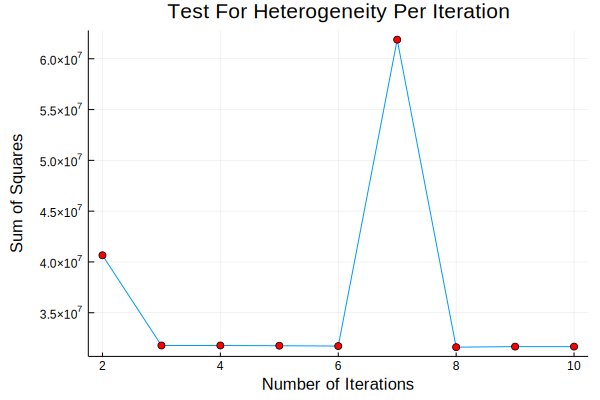

In [11]:
plot(num, ss, ylabel="Sum of Squares", xlabel="Number of Iterations",
     title = "Test For Heterogeneity Per Iteration", legend=false)

scatter!(num, ss, color="red")

In [12]:
ss

9-element Array{Any,1}:
 4.0656481357783034e7
 3.1775625176834874e7
 3.1775625176834874e7
 3.175380681499793e7 
 3.1718695807655618e7
 6.188253174725151e7 
 3.1609285652354963e7
 3.1665206627748072e7
 3.166615786624614e7 

In [15]:
Kmeans(X, 7)[2]

Iteration 1: Jclust = 4.424048914134781.
Iteration 2: Jclust = 30.74937050941666.
Iteration 3: Jclust = 31.774794374784037.
Iteration 4: Jclust = 31.77206906172218.
Successfully terminated with convergence.


7×3 Array{Float64,2}:
   0.148688    1.33227    -1.53401 
  -0.982018    1.01532    -1.21926 
  -1.92226    -1.21761    -1.55213 
   1.16305     2.7205      1.23358 
  -0.375706    0.631342   -1.65563 
 NaN         NaN         NaN       
  -0.498466    0.824046   -0.256313